# Importando Bibliotecas e módulos necessários

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendssdirect as dss
from powerflow.bus import bus_dictionary
from powerflow.batery import distbess_dictionary
from powerflow.generators import distgen_dictionary,add_gd
from powerflow.get_powers import get_dist_power_luiza,get_bus_power
from powerflow.load import add_LoadToBus,add_load
from powerflow.text_comands import set_frequency,new_circuit,line_geometry,add_line,add_infos


# Diretórios dos dados


In [2]:
# Diretório de datasets
dir_datasets = 'C:\\Users\\joao9\\GitHub\\opendss\\datasets\\'

#Diretório de arquivos .dss
dir_dss = dir_datasets + 'arquivos_dss\\'

# Diretório de arquivos de geração PV
dir_pv = 'datasets\\generation_profiles\\'

# Diretório de arquivos de cargas
dir_cargas = 'datasets\\load_profiles\\'


# Definições iniciais do circuito

In [3]:

Text = dss.Text
Circuit = dss.Circuit
Solution = dss.Solution

# Definições da MatPlotLib
plt.close('all')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["figure.dpi"] = 100
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['cmr10']
plt.rcParams['axes.unicode_minus'] = False

#Potências máximas
PowerLoad=4
PowerPV=6 #Potência total dos módulos

# Definições do BESS
Pmin=0.320
BESS_P_MAX = 5
BESS_C_MAX = 12
SOC_MIN = 0.1 # 10%
SOC_MAX = 0.9 # 90%
BESS_E_MIN = BESS_C_MAX * SOC_MIN
BESS_E_MAX = BESS_C_MAX * SOC_MAX

# Definições do intervalo de simulação
# nconsumidores = len(os.listdir(dir_cargas))
nconsumidores = 3
nbarramentos = 4
horas = 24 #hours
intervalo = 30 #min

# Criação do modelo base do arquivo.dss

In [4]:
with open(dir_dss + 'ModelagemTeste.dss', 'w') as file:
    file.write(set_frequency(60) + '\n')
    file.write(new_circuit('ModelagemTeste', str(1).zfill(3), 0.22) + '\n')
    file.write(line_geometry(0.52,0.63,'km',3.338,3,3,[-120.00,0.00,60.00],[1000.00,1000.00,1000.00])+ '\n')
    for i in range(1,nbarramentos,1):
        file.write(add_line(i,str(i).zfill(3),str(i+1).zfill(3),25,'m',3)+ '\n')
    
    file.write(add_infos())

opendssmodel = dir_dss + 'ModelagemTeste.dss'

# Criação dos dicionários que irão armazenar as inforamções das cargas, geraçãoPV e bateria

In [5]:
profiles = os.listdir(dir_cargas)

buses = bus_dictionary(nbarramentos)
for i in range(3):
    bus = 'bus_'+str(i+1).zfill(3)
    name = profiles[i].replace('.csv','')
    add_LoadToBus(buses,bus,name,2,0.22,1000,dir_cargas+profiles[i])

display(buses)

{'bus_001': {'MAC003982': {'phases': 2,
   'voltage': 0.22,
   'power': 1000,
   'profile':                           datetime  Ppower    Qpower
   0      2012-07-06 12:00:00.0000000   0.194  0.000194
   1      2012-07-06 12:30:00.0000000   0.159  0.000159
   2      2012-07-06 13:00:00.0000000   0.161  0.000161
   3      2012-07-06 13:30:00.0000000   0.188  0.000188
   4      2012-07-06 14:00:00.0000000   0.144  0.000144
   ...                            ...     ...       ...
   28818  2014-02-27 22:30:00.0000000   0.123  0.000123
   28819  2014-02-27 23:00:00.0000000   0.133  0.000133
   28820  2014-02-27 23:30:00.0000000   0.146  0.000146
   28821  2014-02-28 00:00:00.0000000   0.193  0.000193
   28822  2014-02-28 00:00:00.0000000   0.193  0.000193
   
   [28823 rows x 3 columns]}},
 'bus_002': {'MAC003983': {'phases': 2,
   'voltage': 0.22,
   'power': 1000,
   'profile':                           datetime  Ppower    Qpower
   0      2012-07-06 12:00:00.0000000   0.098  0.000098
   

# Garantindo que o Opendss esteja limpo

In [6]:
dss.Basic.ClearAll()
dss.Basic.Start(0)
Text.Command("Clear")
Text.Command(f"Compile {opendssmodel}")


# Fluxo de carga

In [ ]:
column_power = ['timestep', 'line', 'bus_1', 'bus_2', 'P', 'Q']
power_df = pd.DataFrame(columns = column_power)

#Descomentar quando for utilizar a função da Luíza

# column_node_power = ['timestep', 'name', 'P', 'Q', 'P_profile', 'Q_profile']
# node_power_df1 = pd.DataFrame(columns=column_node_power)

#Descomentar quando for utilizar a função do João
column_node_power = ['timestep', 'name', 'P', 'Q', 'V_a_b_c']
node_power_df1 = pd.DataFrame(columns=column_node_power)


range_time = pd.date_range('2012-07-06 12:00:00', periods=horas*60/intervalo, freq=str(intervalo)+'T')
for time in range_time:

  dss.Basic.ClearAll()
  dss.Basic.Start(0)
  Text.Command("Clear")
  Text.Command(f"Compile {opendssmodel}")

  #Acessa os barramentos do dicionário
  for bus in buses.keys():
    loads = buses[bus].keys()
    for load in loads:
      carga = buses[bus][load]
      new_command = add_load(time,load,bus, carga['phases'],carga['voltage'], carga['power'], carga['profile'])
      Text.Command(new_command)
 
  Text.Command("Set VoltageBases = [.22]")
  Text.Command("CalcVoltageBases")
  Text.Command("Set maxiterations = 500")
  Text.Command('set mode = snap')
  Text.Command("Solve")

  # Power Flow to DataFrame
  power = np.array(dss.PDElements.AllPowers())
  # print(power)
  power = power.reshape((-1, 6))
  # print(power)
  power = pd.DataFrame(power, columns=['P_a', 'Q_a', 'P_b', 'Q_b', 'P_c', 'Q_c'])
  

  # Create new column that contains sum of specific columns
  power['P'] = power[['P_a', 'P_b', 'P_c']].sum(axis=1)
  power['Q'] = power[['Q_a', 'Q_b', 'Q_c']].sum(axis=1)
  # display(power)
  
  # Get the index for each row of the Data Frame
  power_flow_index = []
  for line in dss.Lines:
      power_flow_index.append([time, line.Name(), line.Bus1(), line.Bus2()])
      power_flow_index.append([time, line.Name(), line.Bus1(), line.Bus2()])
  # print(power_flow_index)

  power[['timestep', 'line', 'bus_1', 'bus_2']] = power_flow_index
  # display(power)
  power_df = pd.concat([power_df, power])
  # display(power_df)


  # Get distributed generation power
  # node_power = get_dist_power_luiza(column_node_power,time,power,buses) # Função Luíza
  node_power = get_bus_power(column_node_power,time,power,buses,dss) # Função João
  


  # Add Grid and Losses power to DataFrame
  # The last "Power Balance" of the system, to be used in the smoothing algorithm.
  node_power = pd.concat([node_power, pd.DataFrame([[time, 'grid', -dss.Circuit.TotalPower()[0], -dss.Circuit.TotalPower()[1], 0]], columns=column_node_power)])
  node_power = pd.concat([node_power, pd.DataFrame([[time, 'losses', dss.Circuit.Losses()[0], dss.Circuit.Losses()[1], 0]], columns=column_node_power)])


  node_power_df1 = pd.concat([node_power_df1, node_power])

  

In [8]:
carga_kw1_SB = []
circuit_kw1_SB =[]
pv6_kw1_SB =[]
bateria_kw1_SB = []
losses_kw1_SB = []
range_time = pd.date_range('2012-07-06 12:00:00', periods=horas*60/intervalo, freq=str(intervalo)+'T')
for timestep in range_time:

    #Filtering power of all buses in specific timestep
    p_values = 0
    for bus in buses.keys():
        filtered_power = node_power_df1[(node_power_df1['timestep'] == timestep) & (node_power_df1['name'].isin([bus]))]
        p_values += filtered_power['P'].values[0]
    carga_kw1_SB.append(p_values)
    
    # Power demand deliverid to circuit
    filtered_grid = node_power_df1[(node_power_df1['timestep'] == timestep) & (node_power_df1['name'].isin(['grid']))]
    grid_values = filtered_grid['P'].values[0]
    circuit_kw1_SB.append(grid_values)

    #Power Losses in the circuit
    filtered_losses = node_power_df1[(node_power_df1['timestep'] == timestep) & (node_power_df1['name'].isin(['losses']))]
    losses_values = filtered_losses['P'].values[0]
    losses_kw1_SB.append(losses_values)

carga_kw_SB = np.array(carga_kw1_SB)
circuit_kw_SB = -np.array(circuit_kw1_SB)
losses_kw = np.array(losses_kw1_SB)

C:\Users\joao9\AppData\Local\Temp\ipykernel_23068\3785727307.py:6: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  range_time = pd.date_range('2012-07-06 12:00:00', periods=horas*60/intervalo, freq=str(intervalo)+'T')
C:\Users\joao9\AppData\Local\Temp\ipykernel_23068\3785727307.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  range_time = pd.date_range('2012-07-06 12:00:00', periods=horas*60/intervalo, freq=str(intervalo)+'T')


C:\Users\joao9\AppData\Local\Temp\ipykernel_23068\4256688563.py:1: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  filtered_time = pd.date_range('12:00:00', periods=horas*60/intervalo, freq=str(intervalo)+'T')
C:\Users\joao9\AppData\Local\Temp\ipykernel_23068\4256688563.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  filtered_time = pd.date_range('12:00:00', periods=horas*60/intervalo, freq=str(intervalo)+'T')


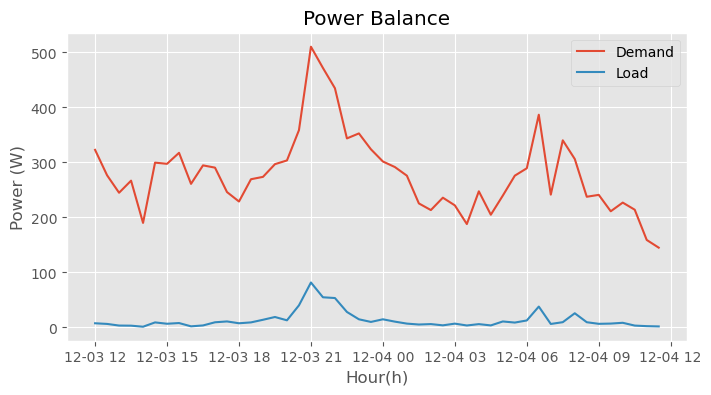

In [9]:
filtered_time = pd.date_range('12:00:00', periods=horas*60/intervalo, freq=str(intervalo)+'T')

plt.plot(filtered_time, -circuit_kw_SB,label='Demand')
plt.plot(filtered_time, carga_kw_SB,label='Load')
# plt.plot(filtered_time, losses_kw,label='Losses')
plt.title('Power Balance')
plt.xlabel('Hour(h)')
plt.ylabel('Power (W)')
plt.legend(loc=1)